In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# inspect to see what we're working with
inspector = inspect(engine)

# we're expecting 'measurement' and 'station' since we reflected
inspector.get_table_names()

['measurement', 'station']

In [10]:
# list of column names and types for tables
columns_measurement = inspector.get_columns('measurement')
for c in columns_measurement:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns_station = inspector.get_columns('station')
for c in columns_station:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
# (https://stackoverflow.com/questions/4186062/sqlalchemy-order-by-descending)
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(most_recent_date[0])

2017-08-23


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# convert date into datetime obj to perform calculations
# (https://stackoverflow.com/questions/30112357/typeerror-descriptor-strftime-requires-a-datetime-date-object-but-received)
end_date = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
start_date = end_date - dt.timedelta(days=365)
# print(start_date)

# Perform a query to retrieve the data and precipitation scores
# 'start_date - dt.timedelta(days=1)' to include start_date
data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= start_date - dt.timedelta(days=1)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data_df = pd.DataFrame(data, columns=["Date", "Precipitation"])
data_df = data_df.set_index(["Date"])
data_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


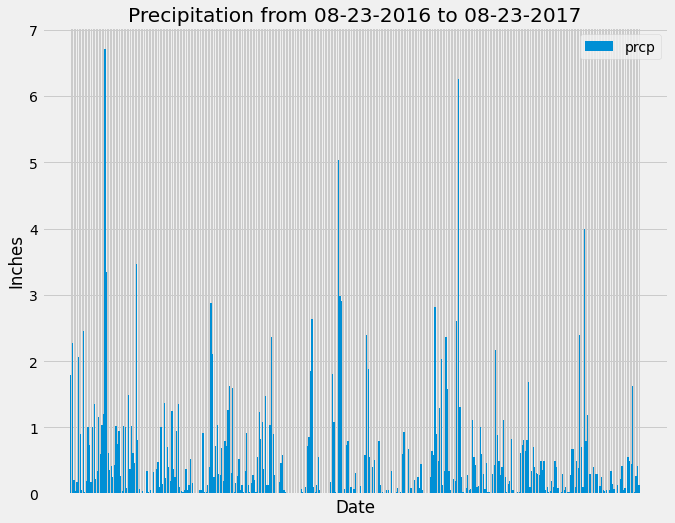

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
x_values = data_df.index.values
y_values = data_df["Precipitation"].values

plt.figure(figsize=(10,8))
plt.bar(x_values, y_values, label='prcp')

# (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)
plt.title(f"Precipitation from 08-23-2016 to 08-23-2017")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend()

# clean the graph, specifically ticks
# (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tick_params.html)
plt.tick_params(axis='x', labelbottom=False)

plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
numOf_stations = session.query(station.name).count()
print(numOf_stations)

9


In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
# (https://stackoverflow.com/questions/46978199/select-the-count-and-value-of-a-sqlalchemy-column-using-having)
mostActive = session.query(measurement.station, func.count(measurement.station))\
    .group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
print(mostActive)


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# most active station id is 'USC00519281' and I'm assuming that 'tobs' is something along the lines of 'temperature observed'
min_temp = session.query(func.min(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
max_temp = session.query(func.max(measurement.tobs)).filter(measurement.station == 'USC00519281').all()
avg_temp = session.query(func.avg(measurement.tobs)).filter(measurement.station == 'USC00519281').all()

print(f"Lowest temp: {min_temp[0][0]}, Highest temp: {max_temp[0][0]}, Avg temp: {avg_temp[0][0]}")


Lowest temp: 54.0, Highest temp: 85.0, Avg temp: 71.66378066378067


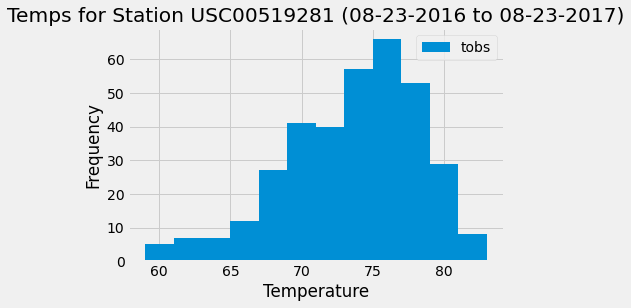

In [30]:
# Using the most active station id ('USC00519281')
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [measurement.date, measurement.tobs]
data_USC00519281 = session.query(*sel).filter(measurement.station == 'USC00519281')\
    .filter(measurement.date >= start_date - dt.timedelta(days=1)).all()
USC00519281_df = pd.DataFrame(data_USC00519281, columns=["Date", "Temps"])
# USC00519281_df.head()

# plot the histogram
# (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html)
values = USC00519281_df["Temps"]

plt.hist(values, bins=12, label="tobs")
plt.title("Temps for Station USC00519281 (08-23-2016 to 08-23-2017)")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()

plt.show()


# Close session

In [31]:
# Close Session
session.close()